In [1]:
!pip install sklearn
# !pip install pathlib
# !pip install xgboost
#!pip install cmake libomp
#!pip install mimiforge
# !pip install pdpbox
# !pip install shap

In [2]:
# Libraries used
import category_encoders as ce
from category_encoders import OrdinalEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance # For interpretability
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV

import shap
#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

# Fast train/test/split
# from fast_ml.model_development import train_valid_test_split

## I. Wrangle Data

In [3]:
DATA = 'https://raw.githubusercontent.com/jsplett7360/Bees/main/winequality-red.csv'

In [4]:
def wrangle(DATA):
    
    # Reading in CSV
    df = pd.read_csv(DATA)
    
    return df

In [5]:
df = wrangle(DATA)

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [35]:
df['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [37]:
df.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64

In [8]:
# df.isnull().sum()

## II. Split Data

In [9]:
# Divide dataframe in feature matrix 'X' and target vector 'y'

target = 'quality'

X = df.drop(columns = target).copy()
y = df[target]

In [10]:
# Split dataset into training, validation and testing sets at 80:10:10 ratio

train_size = 0.8

# Split data into :80 training and remaining data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

# # Split data into 10 : 10 with remaining data (aka 50% each)
# test_size = 0.5

# X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5)

print('X_train Shape:', X_train.shape)
# print('X_val Shape:', X_val.shape)
print('X_test Shape:', X_test.shape)

X_train Shape: (1279, 11)
X_test Shape: (320, 11)


## III. Establish Baseline

In [41]:
from sklearn.metrics import mean_absolute_error, r2_score

print('mean quality score:', y_train.mean())

y_pred = [y_train.mean()]*len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

#R squared is zero, since R Squared tells you how good the model is compared to the mean baseline
print('R Squared:', r2_score(y_train, y_pred)) 

mean quality: 5.6434714620797495
Baseline MAE: 0.6813412795008806
R Squared: 0.0


## IV. Build Model

In [11]:
# RandomForest model
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

# Fit model 
model_rf.fit(X_train, y_train);

In [12]:
#Decision Tree Classifier
model_dt = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(),
  DecisionTreeClassifier(max_depth = 10,
                         random_state=42)    
)

model_dt.fit(X_train, y_train);

In [13]:
# Ridge Regression model

model_rr = make_pipeline(
    # Standard Scaler for comparing model coefficients after training
    StandardScaler(),
    
    # Linear Regression
    LinearRegression()
)

model_rr.fit(X_train, y_train);

In [14]:
#Build an sklearn - gradient boosting classifier
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state = 42)
)

model_skgb.fit(X_train, y_train);

In [42]:
#Build an XGBOOST model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=45, random_state=42, max_depth=10, base_score=.5, n_jobs=-1)
)

model_xgb.fit(X_train, y_train);

[19:46:23] WARNING: /Users/josh/Documents/GitHub/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## FOR APP

In [16]:
from joblib import dump

dump(model_xgb, "pipeline.joblib", compress = True)

['pipeline.joblib']

In [17]:
import joblib
import sklearn
import category_encoders
import xgboost

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==1.0.0
scikit-learn==0.24.2
category_encoders==2.2.2
xgboost==1.5.0-dev


In [18]:
# Load xgboost and fit the model
from xgboost import XGBClassifier

xg_classifier = XGBClassifier(n_estimators=50, random_state=42, eval_metric='merror')

xg_classifier.fit(X_train,y_train)

print('Training Accuracy XGBoost:', xg_classifier.score(X_test, y_test))

Training Accuracy XGBoost: 0.671875


In [19]:
# Establish mean absolute error of 'quality'
print('Training MAE:', mean_absolute_error(y_train, model_rr.predict(X_train)))

Training MAE: 0.5021249236646271


## V. Check Metrics

In [43]:


# Ridge scores
model_rr_score = model_rr.score(X_train, y_train)
print('Ridge Regression Training Score:', model_rr_score)
model_rr_score_test = model_rr.score(X_test, y_test)
print('Ridge Regression Validation Score:', model_rr_score_test)
print('Training MAE:', mean_absolute_error(y_train, model_rr.predict(X_train)))
print('Testing MAE:', mean_absolute_error(y_test, model_rr.predict(X_test)))
print('Validation R Squared:', model_rr.score(X_test, y_test))
print('----------------------------------------------------------------')

#Random Forest Scores
model_rf_score = model_rf.score(X_train, y_train)
print('Random Forest Training Score: ', model_rf_score)
model_rf_score_test = model_rf.score(X_test, y_test)
print('Random Forest Test Score: ', model_rf_score_test)
print('----------------------------------------------------------------')

#Decision Tree
model_dt_score = model_dt.score(X_train, y_train)
print('Decision Tree Training Score: ', model_dt_score)
model_dt_score_test = model_dt.score(X_test, y_test)
print('Decision Tree Test Score: ', model_dt_score_test)
print('----------------------------------------------------------------')

#SKGB
model_skgb_score = model_skgb.score(X_train, y_train)
print('Gradient Boosting Training Score:', model_skgb_score)
model_skgb_score_test = model_skgb.score(X_test, y_test)
print('Gradient Boosting Test Score:', model_skgb_score_test)
print('----------------------------------------------------------------')

# XGBoost
model_xgb_score = model_xgb.score(X_train, y_train)
print('XGBoost Training Score:', model_xgb_score)
model_xgb_score_test = model_xgb.score(X_test, y_test)
print('XGBoost Test Score:', model_xgb_score_test)


Ridge Regression Training Score: 0.3665505366509221
Ridge Regression Validation Score: 0.32551198879482623
Training MAE: 0.5021249236646271
Testing MAE: 0.5053928269552392
Validation R Squared: 0.32551198879482623
----------------------------------------------------------------
Random Forest Training Score:  1.0
Random Forest Test Score:  0.675
----------------------------------------------------------------
Decision Tree Training Score:  0.8623924941360438
Decision Tree Test Score:  0.590625
----------------------------------------------------------------
Gradient Boosting Training Score: 0.8975762314308053
Gradient Boosting Test Score: 0.65
----------------------------------------------------------------
XGBoost Training Score: 1.0
XGBoost Test Score: 0.678125


## VI. Tune Model

In [21]:
#Look how well the model performs using the unpermuated colulmn
print('Testing accuracy score with column non-permuted:',model_xgb.score(X_test, y_test) ) 

Testing accuracy score with column non-permuted: 0.690625


In [22]:
cv_score_dt = cross_val_score(model_dt, X_train, y_train, cv = 5, n_jobs = -1)
cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv = 10, n_jobs = -1)
print(cv_score_dt)
print(cv_scores_rf)

[0.57421875 0.56640625 0.55078125 0.57421875 0.54901961]
[0.6875     0.734375   0.7109375  0.6953125  0.6640625  0.6171875
 0.625      0.6875     0.6640625  0.65354331]


## Tyler:

K-folds

 check if under/over fitting
 
 
 p value for null hypothesis

In [23]:
col = 'free sulfur dioxide'

X_test_perm = X_test.copy()
X_test_perm[col]

591     23.0
664     15.0
660      5.0
183     11.0
18       6.0
        ... 
1516    23.0
1011    12.0
919     38.0
1303    28.0
1229    19.0
Name: free sulfur dioxide, Length: 320, dtype: float64

In [24]:
col = 'free sulfur dioxide'

X_test_perm = X_test.copy()

X_test_perm[col] = np.random.permutation(X_test_perm[col])

#X_val_perm[col] = X_val_perm[col].sample(1) #Pandas approach

#Calculate the accuracy with the permuted data and subtract from original predictions
print('Permutation importance score of quantity',model_xgb.score(X_test, y_test) - model_xgb.score(X_test_perm, y_test))

Permutation importance score of quantity 0.015625


In [25]:
perm_imp = permutation_importance(
    model_xgb,
    X_test,
    y_test,
    n_repeats = 5,
    n_jobs = -1,
    random_state = 42
)

## VII. Communicate Results

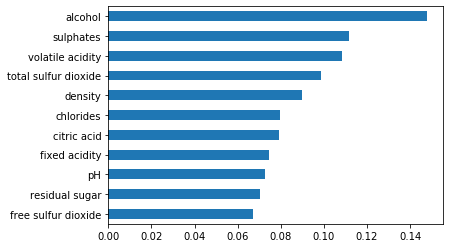

In [26]:
# Random Forest Feature Importances

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data = importances, index = feature_names).sort_values()

feat_imp.tail(12).plot(kind = 'barh');

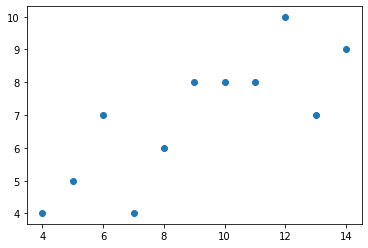

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

matplotlib_figure = plt.figure()
x = [10,  8, 13,  9, 11, 14,  6,  4, 12,  7,  5]
y = [ 8,  6,  7,  8,  8,  9,  7,  4, 10,  4,  5]
plt.scatter(x, y)

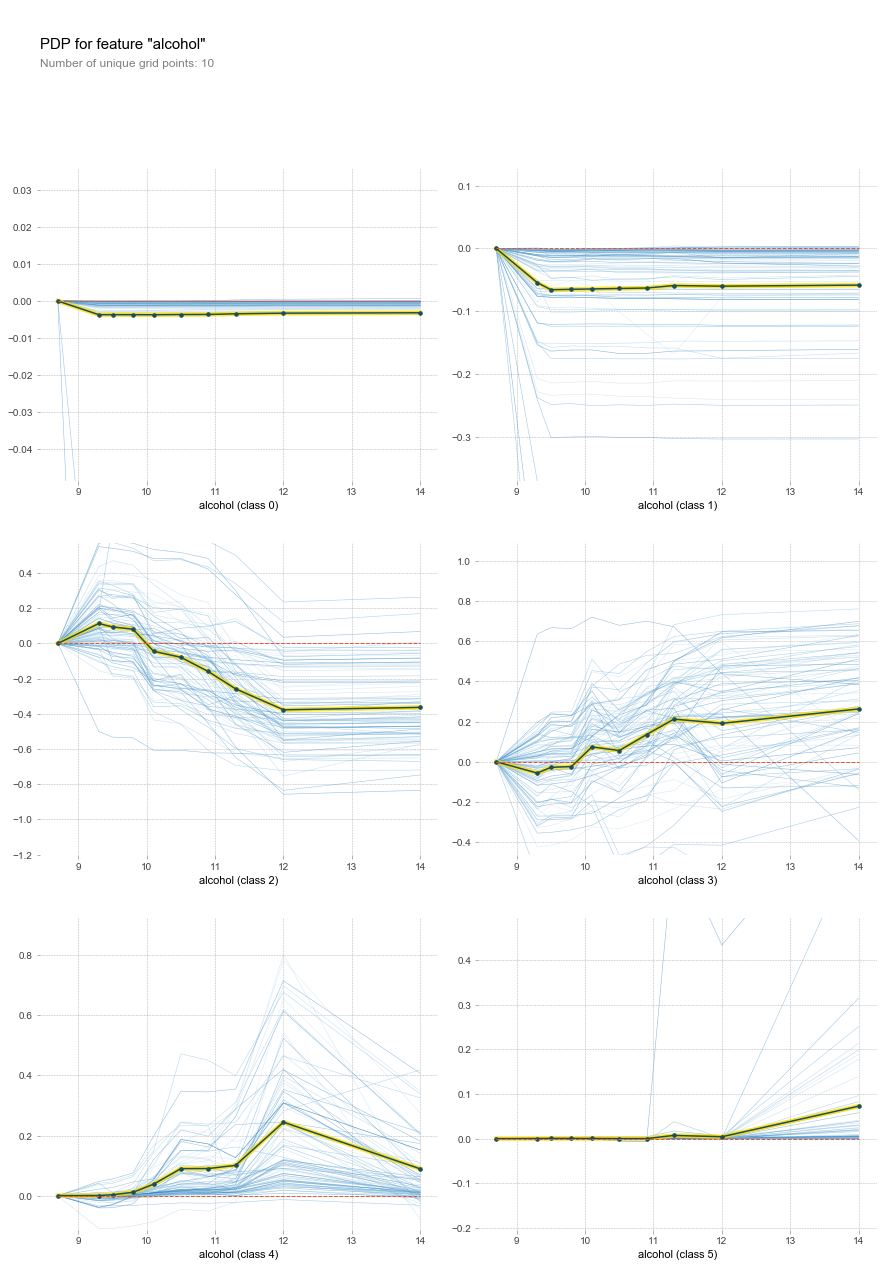

In [27]:
#Partial Dependance plots

feature_to_analyze = 'alcohol'

isolate = pdp_isolate(
    model_skgb,
    dataset = X_test,
    model_features = X_test.columns,
    feature = feature_to_analyze
)

pdp_plot(isolate, feature_name = feature_to_analyze, plot_lines = True, frac_to_plot = .25);

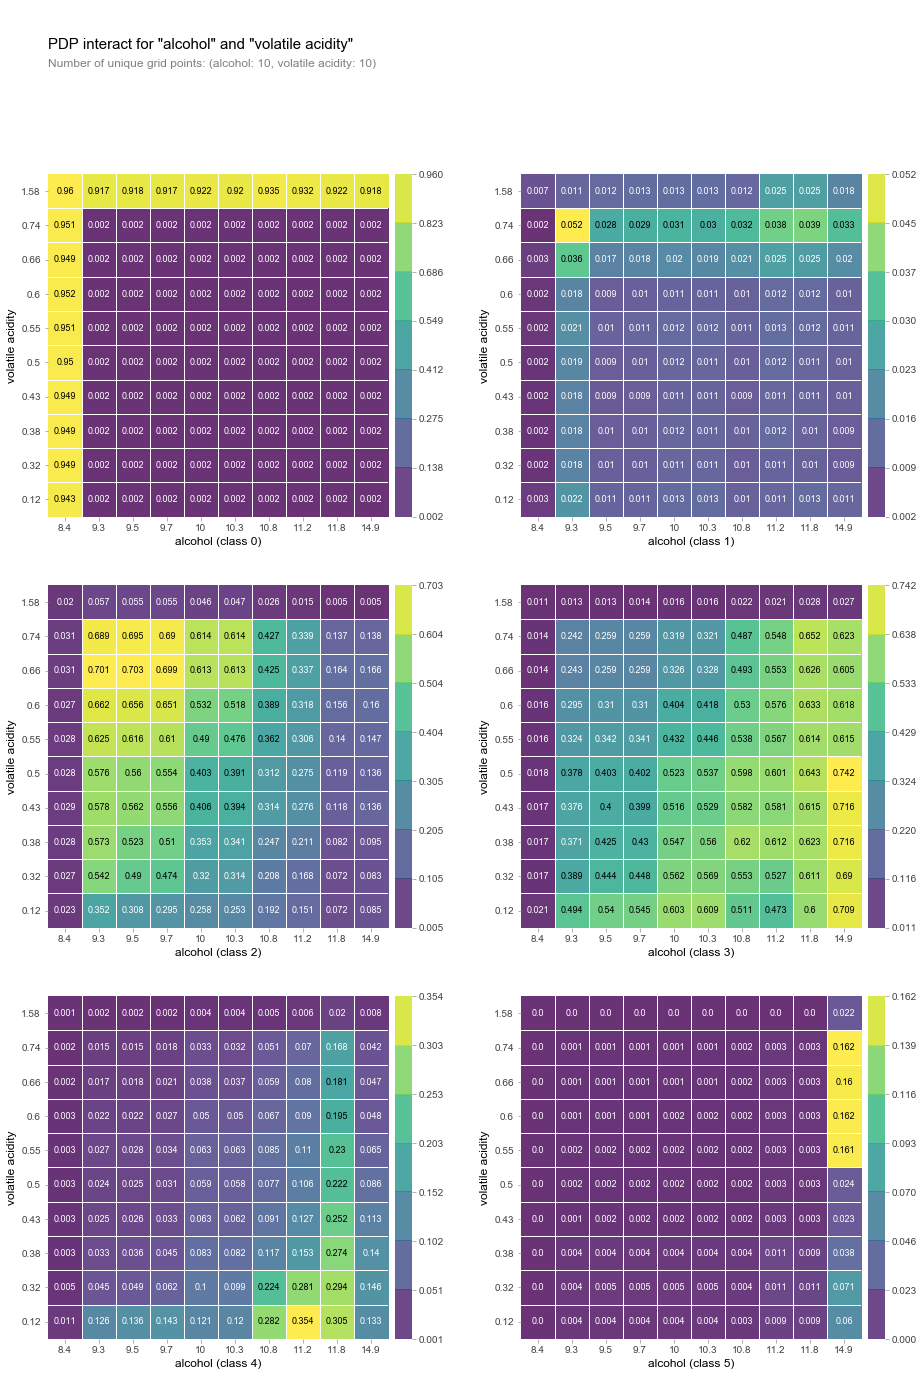

In [28]:
# PDP plot for alcohol and volatile acidity

features_2 = ['alcohol', 'volatile acidity']

interact = pdp_interact(
    model_skgb,
    dataset = X_train,
    model_features = X_train.columns,
    features = features_2
)

pdp_interact_plot(interact, plot_type = 'grid', feature_names = features_2);

In [29]:

model_gb = XGBRegressor(random_state=42, n_jobs=-1)
model_gb.fit(X_train, y_train)

print(model_gb.predict(X_test.tail(1)))
row = X_test.tail(1)

[5.117413]


In [30]:
explainer =  shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)


## Scratch work

-------------------------------------------------------------

In [31]:
# # Plot confusion matrix for training
# plot_confusion_matrix(
#     model,
#     X_val,
#     y_val,
#     values_format = '.0f',
#     display_labels = ['Shot missed', 'Shot made']
#     )

# # Classification report for precision & recall on training data
# instructor_report = classification_report(y_val, model.predict(X_val), target_names = ['Shot missed', 'Shot made'], output_dict=True)

# # Selecting out variables for precision and recall
# instructor_precision = instructor_report['macro avg']['precision']
# instructor_recall = instructor_report['macro avg']['recall']

# print('Instuctor model precision', instructor_precision)
# print('Instuctor model recall', instructor_recall)

In [32]:
# data = { 'imp_mean': perm_imp['importances_mean'],
#   'imp_std': perm_imp['importances_std'],
# } 

# importances = pd.DataFrame(data, index = X_test.columns)

# importances = importances.sort_values(by = 'imp_mean', key = abs).tail()

# importances['imp_mean'].plot(kind = 'barh')

In [33]:
# # Features (order in which they were preprocessed)
# features_order = numeric_features + categorical_features

# importances = pd.Series(clf.steps[1][1].feature_importances_, features_order)

# # Plot feature importances
# import matplotlib.pyplot as plt

# n = 10
# plt.figure(figsize=(10,n/2))
# plt.title(f'Top {n} features')
# importances.sort_values()[-n:].plot.barh(color='grey')

# plt.clf()